# Stage 2: Data Annotation

In this notebook, I'll leverage a Large Language Model (LLM) to perform sentiment annotation on the ESG document dataset, assigning scores of 0 for negative, 0.5 for neutral, and 1 for positive sentiment.  
The workflow involves manually creating a "gold standard" by annotating ~500 sentences, afterward setting up 2-3 LLMs for trial annotations, and experimenting with prompting strategies (zero-shot/few-shot) that we'll evaluate against the "gold standard".

## Setup & Data Loading

In [1]:
# Imports
import os
import re
import ast
import pandas as pd
import numpy as np
import openai
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import pipeline
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm
tqdm.pandas()

In [2]:
# Load the preprocessed data
cleaned_data = pd.read_csv('../data/checkpoints/enriched_cleaned_data.csv', delimiter = '|')

In [3]:
# Define a function to convert a string representation of a list to a list datatype
def string_to_list(string):
    try:
        return ast.literal_eval(string)
    except (ValueError, SyntaxError):
        print('List conversion failed')
        return []

def set_datatypes(df):
    # Convert the string representations of the lists to the correct 'list' datatype
    df['word_tokens'] = df['word_tokens'].apply(string_to_list)
    df['sentence_tokens'] = df['sentence_tokens'].apply(string_to_list)
    df['pos_tagged_word_tokens'] = df['pos_tagged_word_tokens'].apply(string_to_list)
    df['pos_tagged_sentence_tokens'] = df['pos_tagged_sentence_tokens'].apply(string_to_list)
    df['esg_topics'] = df['esg_topics'].apply(string_to_list)
    
    # Convert date to correct datatype
    df['date'] = pd.to_datetime(df['date'])

    # Derive year and month to aggregate
    df['year_month'] = df['date'].apply(lambda x: x.strftime('%Y-%m'))
    df['year'] = df['date'].apply(lambda x: x.strftime('%Y'))
    df['month'] = df['date'].apply(lambda x: x.strftime('%m'))

    return df

In [4]:
# Set the correct datatypes, e.g. lists and datetime
cleaned_data = set_datatypes(cleaned_data)

In [5]:
# Define function to save intermediary steps in a file
def csv_checkpoint(df, filename='checkpoint'):
    """
    Saves a DataFrame to a CSV file and loads it back into a DataFrame.

    Args:
        df (pandas.DataFrame): The DataFrame to save and load.
        filename (str): The name of the CSV file to save the DataFrame to (default: 'checkpoint').

    Returns:
        pandas.DataFrame: The loaded DataFrame.
    """
    if not os.path.exists('./checkpoints/'):  # Check if the directory exists and create it if it doesn't
        os.makedirs('./checkpoints/')

    # Save DataFrame to CSV
    df.to_csv(f'./checkpoints/{filename}.csv', index=False, sep='|')  # Save DataFrame to CSV with specified filename
    print(f'Saved DataFrame to {filename}.csv')

    # Load CSV back into DataFrame
    df = pd.read_csv(f'./checkpoints/{filename}.csv', delimiter='|')  # Load CSV back into DataFrame
    print(f'Loaded DataFrame from {filename}.csv')

    return df

## Manual sentence sentiment annotation

To define a "gold standard" for the sentiment, 500 randomly sampled sentences are manually annotate with:  
**0 = negative, 0.5 = neutral, 1 = positive**

In [6]:
# Crate a deep copy so no reload from CSV files is necessary is something goes wrong
documents = cleaned_data.copy(deep=True)

In [7]:
# Explode the dataset based on the sentence tokens, so each row contains one sentence
documents = documents.explode('sentence_tokens')

# Drop rows with no sentence
documents = documents.dropna(subset=['sentence_tokens'])

# Preserve original index, so a later aggregation is possible but rows have unique index
documents['original_index'] = documents.index

# Reset the index
documents = documents.reset_index(drop=True)

The ratio of internal and external documents is quite imbalanced (see EDA).  
Therefore an oversampling for interal sentences is considered to get a ratio of 20/80 (internal/external) sentences.

In [8]:
# Separate the DataFrame into internal/external sentences with a defined ratio
internal = documents[documents['internal'] == 1]
external = documents[documents['internal'] == 0]

# Determine the number of samples from each group, 1000 sentences in total
n_internal = int(0.2 * 1000)  # 20% of samples
n_external = 1000 - n_internal  # Remaining samples

# Sample 1000 random sentences with a seed, so a re-run samples the same sentences
sampled_internal = internal.sample(n=n_internal, random_state=42)
sampled_external = external.sample(n=n_external, random_state=42)

# Concatenate and shuffle the samples the DataFrames
sampled_documents = pd.concat([sampled_internal, sampled_external])
sampled_documents = sampled_documents.sample(frac=1, random_state=42)

In [9]:
# Craete new column to store the sentence sentiment
sampled_documents['sentiment_manual'] = np.nan

In [10]:
# Check the sampled data
sampled_documents[['title','sentence_tokens','internal','sentiment_manual']].head()

,title,sentence_tokens,internal,sentiment_manual
529113,Transcript levels in plasma contribute substan...,therefore adjust differences sample quality in...,0,NaN
339673,Absolutely everything you need to go bikepacki...,way little quicker easier make coffee porridge...,0,NaN
390711,STARTUP STAGE: Tripshifu connects experienced ...,started career multinational tata steel joinin...,0,NaN
354554,Automotive Aftermarket Market by Global Busine...,notable trend currently influencing dynamics a...,0,NaN
420428,Smashing Podcast Episode 50 With Marko Dugonji...,know never used tables layout,0,NaN


Within a loop, all sentences are manually annotated.  
With a "+" a sentence is flagged as positive (1.0), a "-" marks a negative (0.0) sentence and "Enter" (no value) flags the sentence as neutral (0.5).

In [11]:
# Loop the samples to annotate them
for idx, row in sampled_documents.iterrows():
    # Loop until valid input is received
    while True:
        # Print the title of the document and the sentence
        print(f"Title: {row['title']}\nSentence: {row['sentence_tokens']}\n")

        # Wait for user input
        sentiment = input("Enter sentiment value (+ for 1.0, - for 0.0, Enter for 0.5): ")

        # Check if the input is valid
        if sentiment == '+':
            sampled_documents.at[idx, 'sentiment_manual'] = 1.0
            break
        elif sentiment == '-':
            sampled_documents.at[idx, 'sentiment_manual'] = 0.0
            break
        elif sentiment == '':
            sampled_documents.at[idx, 'sentiment_manual'] = 0.5
            break
        else:
            print("Invalid input. Please try again.")

Title: Transcript levels in plasma contribute substantial predictive value as potential Alzheimer's disease biomarkers in African Americans
Sentence: therefore adjust differences sample quality including concentration rin potential differences due banking time potential interindividual differences fasting status medications implemented linear mixed model obtaining random effect estimates sample

Title: Absolutely everything you need to go bikepacking: the complete guide to what you need to take
Sentence: way little quicker easier make coffee porridge mornings

Title: STARTUP STAGE: Tripshifu connects experienced travelers with those seeking advice
Sentence: started career multinational tata steel joining employees helped turn one topselling memory brands across ecommerce portals

Title: Automotive Aftermarket Market by Global Business Opportunity, Development, Growth Factors, Applications Analysis and Future Prospects 2028 – EcoChunk
Sentence: notable trend currently influencing dynami

In [12]:
# Save the manual annotations to CSV (whole dataframe is too big to store on GitHub, therefore only sentences and manual annotations are stored)
if not os.path.exists('./annotated/'):  # Check if the directory exists and create it if it doesn't
    os.makedirs('./annotated/')
sampled_documents[['sentiment_manual', 'sentence_tokens']].to_csv(f'./annotated/esg_document_sentence_samples_annotated.csv', index=False, sep='|')

In [16]:
# Check the manually annotated data
sampled_documents[sampled_documents['sentiment_manual'].notnull()].head()

,company,datatype,date,domain,esg_topics,internal,symbol,title,cleaned_content,word_tokens,...,pos_tagged_sentence_tokens,market_cap_in_usd_b,sector,industry,sentiment_value,year_month,year,month,original_index,sentiment_manual
529113,Qiagen,thinktank,2022-03-17,thelancet,"[GenderDiversity, Privacy]",0,QIA,Transcript levels in plasma contribute substan...,aa remain underrepresented alzheimers disease ...,"[aa, remain, underrepresented, alzheimers, dis...",...,"[[(aa, NN), (remain, VBP), (underrepresented, ...",11.38,Healthcare,Diagnostics & Research,0.100772,2022-03,2022,03,7601,0.5
339673,Beiersdorf,general,2021-04-27,cyclingweekly,"[Compliance, Recycling, CustomerService, Gende...",0,BEI,Absolutely everything you need to go bikepacki...,get know area far intimately staying accommoda...,"[get, know, area, far, intimately, staying, ac...",...,"[[], [(get, VB), (know, VBP), (area, NN), (far...",25.99,Consumer Staples,Household & Personal Products,0.314033,2021-04,2021,04,2774,1.0
390711,Deutsche Bank,general,2022-09-26,phocuswire,"[HumanCapital, Social, Recruiting, Misinformat...",0,DBK,STARTUP STAGE: Tripshifu connects experienced ...,founded february currently five employee idea ...,"[founded, february, currently, five, employee,...",...,"[[(founded, VBN), (february, JJ), (currently, ...",24.97,Financials,Banks,0.249278,2022-09,2022,09,4228,0.5
354554,Continental,general,2021-10-05,ecochunk,[RussianFederation],0,CON,Automotive Aftermarket Market by Global Busine...,recording estimating analysing market data rep...,"[recording, estimating, analysing, market, dat...",...,"[[(recording, VBG), (estimating, VBG), (analys...",13.27,Consumer Discretionary,Auto Parts,0.280167,2021-10,2021,10,3046,0.5
420428,Deutsche Telekom,business,2022-08-09,smashingmagazine,"[CorporateCulture, HumanCapital, Environment, ...",0,DTE,Smashing Podcast Episode 50 With Marko Dugonji...,ask affect change ux design large organization...,"[ask, affect, change, ux, design, large, organ...",...,"[[(ask, JJ), (affect, VBP), (change, NN), (ux,...",101.78,Communication Services,Telecom Services,0.203908,2022-08,2022,08,4946,0.5


## LLM Annotation Tests

### Test LLM's with prompting strategies
To test different prompting strategies, ChatGPT and FLAN-T5 is used.

In [17]:
# Check if API key file exists
API_KEY = open('api_key.txt', 'r').read().strip() if os.path.exists('api_key.txt') else input("Please enter your OpenAI/ChatGPT API key: ").strip()
if len(API_KEY) <= 20: raise ValueError("Invalid OpenAI API key. Please ensure your API key is correct.")

# Set up the OpenAI API client
openai.api_key = API_KEY

prompt = 'Classify the sentiment in the following text (0.0 for negative, 0.5 for neutral and 1.0 for positve):'
text = "I love homework"

response = openai.Completion.create(
  model="text-davinci-003",
  prompt=f'{prompt}\n\n {text}',
  temperature=0,
  max_tokens=10,
  top_p=1.0,
  frequency_penalty=0.0,
  presence_penalty=0.0
)

sentiment = response.choices[0].text.strip()
print(sentiment)

1.0


In [18]:
# https://huggingface.co/docs/transformers/model_doc/flan-t5

model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base")
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base", max_new_tokens=100)

prompt = 'Classify the sentiment in the following text (0.0 for negative, 0.5 for neutral and 1.0 for positve):'
text = 'Im feeling okay'

input_text = f'{prompt} {text}'
input_ids = tokenizer(input_text, return_tensors="pt").input_ids

outputs = model.generate(input_ids)
print(tokenizer.decode(outputs[0]))

<pad> 0.5</s>


/Users/tim/.pyenv/versions/3.10.10/envs/venv-nlp/lib/python3.10/site-packages/transformers/generation/utils.py:1346: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


### Predicting the Sentiment directly with different Models (zero-shot)

Huggingface offers a huge variety of pre-trained models for NLP tasks, including already finetuned models for sentiment analysis:  
https://huggingface.co/models?pipeline_tag=text-classification&sort=likes&search=sentiment


First, a fe are tested "by hand" to get a feeling of the predicted scores and the model's capabilities.

In [19]:
# Generic function to run a Huggingface pipeline and extract the sentiment value
def get_sentiment_score_single(sentence, pipeline):
    return pipeline(sentence)[0]

In [20]:
roberta_l = pipeline("sentiment-analysis", model="siebert/sentiment-roberta-large-english")
sentence = "I love this product! It's really amazing."
print(get_sentiment_score_single(sentence, roberta_l))

Xformers is not installed correctly. If you want to use memorry_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


{'label': 'POSITIVE', 'score': 0.9988968372344971}


In [21]:
roberta_l = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")
sentence = "I love this product! It's really amazing."
print(get_sentiment_score_single(sentence, roberta_l))

{'label': 'POSITIVE', 'score': 0.9998865127563477}


In [22]:
roberta_l = pipeline("sentiment-analysis", model="Seethal/sentiment_analysis_generic_dataset")
sentence = "I love this product! It's really amazing."
print(get_sentiment_score_single(sentence, roberta_l))

{'label': 'LABEL_2', 'score': 0.9965908527374268}


In the following code snippet, multiple models from Huggingface can be specified to predict the sentiment of all sampled sentences.  
The sentiment value is stored and can be used for later comparison.

In [23]:
TOKENIZERS_PARALLELISM=False

# List of Huggingface models to use
models = ['cardiffnlp/twitter-roberta-base-sentiment','distilbert-base-uncased-finetuned-sst-2-english', 'Seethal/sentiment_analysis_generic_dataset','siebert/sentiment-roberta-large-english', 'nlptown/bert-base-multilingual-uncased-sentiment']

def get_sentiment_score(nlp, sentence):
    result = nlp(sentence)[0]
    score = result['score']
    return score

# Apply each model to the dataframe and store the results in a new column
for model in models:
    print(f'Running sentiment analysis with model: {model}')
    nlp = pipeline('sentiment-analysis', model=model, use_fast=True) 
    sampled_documents[model] = sampled_documents['sentence_tokens'].progress_apply(lambda x: get_sentiment_score(nlp, x))

Running sentiment analysis with model: cardiffnlp/twitter-roberta-base-sentiment
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 1000/1000 [00:42<00:00, 23.56it/s]


Running sentiment analysis with model: distilbert-base-uncased-finetuned-sst-2-english


100%|██████████| 1000/1000 [00:24<00:00, 40.02it/s]


Running sentiment analysis with model: Seethal/sentiment_analysis_generic_dataset


100%|██████████| 1000/1000 [00:21<00:00, 46.44it/s]


Running sentiment analysis with model: siebert/sentiment-roberta-large-english


100%|██████████| 1000/1000 [01:54<00:00,  8.74it/s]


Running sentiment analysis with model: nlptown/bert-base-multilingual-uncased-sentiment


100%|██████████| 1000/1000 [00:47<00:00, 21.10it/s]


In [24]:
# Function for Google's FLAN model
def get_sentiment_flan(sentence, prompt, model, tokenizer):
    input_text = f'{prompt} {sentence}'
    input_ids = tokenizer(input_text, return_tensors="pt").input_ids
    outputs = model.generate(input_ids)
    sentiment = tokenizer.decode(outputs[0])
    
    # Extract float using regex
    match = re.search(r'\d+\.\d+', sentiment)  # Extract only sentiment value
    if match:
        sentiment = float(match.group())
    else:
        sentiment = np.nan 
    
    return sentiment

# Function for OpenAI's text-davinci model
def get_sentiment_gpt(sentence, prompt):
    response = openai.Completion.create(
        model="text-davinci-003",
        prompt=f'{prompt}\n\n{sentence}',
        temperature=0,
        max_tokens=10,
        top_p=1.0,
        frequency_penalty=0.0,
        presence_penalty=0.0)

    # Extract float using regex
    match = re.search(r'\d+\.\d+', response)  # Extract only sentiment value
    if match:
        response = float(match.group())
    else:
        response = np.nan 
    
    return response

# Running the sentiment analysis with pre-defined functions/prompts for FLAN and ChatGPT
model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base")
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")
prompt_flan = 'Classify the sentiment in the following text with "0.0" for negative, "0.5" for neutral and "1.0" for positive:'
print('Running sentiment analysis with Google FLAN model')
sampled_documents['flan'] = sampled_documents['sentence_tokens'].progress_apply(lambda x: get_sentiment_flan(x, prompt_flan, model, tokenizer))

openai.api_key = API_KEY
prompt_gpt = 'Classify the sentiment in the following text with "0.0" for negative, "0.5" for neutral and "1.0" for positive:'
print('Running sentiment analysis with OpenAI davinci model')
sampled_documents['chat_gpt'] = sampled_documents['sentence_tokens'].progress_apply(lambda x: get_sentiment_gpt(x, prompt_gpt))

Running sentiment analysis with Google FLAN model


  0%|          | 0/1000 [00:00<?, ?it/s]/Users/tim/.pyenv/versions/3.10.10/envs/venv-nlp/lib/python3.10/site-packages/transformers/generation/utils.py:1346: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100%|██████████| 1000/1000 [01:57<00:00,  8.49it/s]


Running sentiment analysis with OpenAI davinci model


  1%|          | 11/1000 [00:11<17:20,  1.05s/it]


ValueError: could not convert string to float: 'ally, the economy is improving\n\n1.'

## Comparison of the different LLM

In [38]:
sampled_documents[models+ ['flan','sentiment_manual']].head(25)

,cardiffnlp/twitter-roberta-base-sentiment,distilbert-base-uncased-finetuned-sst-2-english,Seethal/sentiment_analysis_generic_dataset,siebert/sentiment-roberta-large-english,nlptown/bert-base-multilingual-uncased-sentiment,flan,sentiment_manual
529113,0.868482,0.968752,0.986274,0.995720,0.374006,1.0,0.5
339673,0.694643,0.994828,0.832007,0.998569,0.290113,0.0,1.0
390711,0.676100,0.997667,0.985466,0.998429,0.679434,1.0,0.5
354554,0.691235,0.997449,0.997484,0.995504,0.563777,1.0,0.5
420428,0.557583,0.753011,0.983506,0.997035,0.355870,0.0,0.5
457123,0.466555,0.860434,0.988677,0.920602,0.700592,0.0,0.5
669146,0.861617,0.999638,0.993177,0.997528,0.451193,0.5,0.5
452818,0.616002,0.985258,0.640174,0.998287,0.288888,1.0,0.5
265897,0.572065,0.999541,0.996951,0.995354,0.538699,1.0,0.5
236198,0.832328,0.968791,0.995347,0.996854,0.436993,0.5,0.5


In [31]:
# Function to normalize scores with defined cut-off borders
def normalize_score(score):
    if score <= 0.33:
        return 0.0
    elif score <= 0.66:
        return 0.5
    else:
        return 1.0

# Apply the normalization for each sentiment score
for model in models:
    sampled_documents[model + '_norm'] = sampled_documents[model].apply(normalize_score)

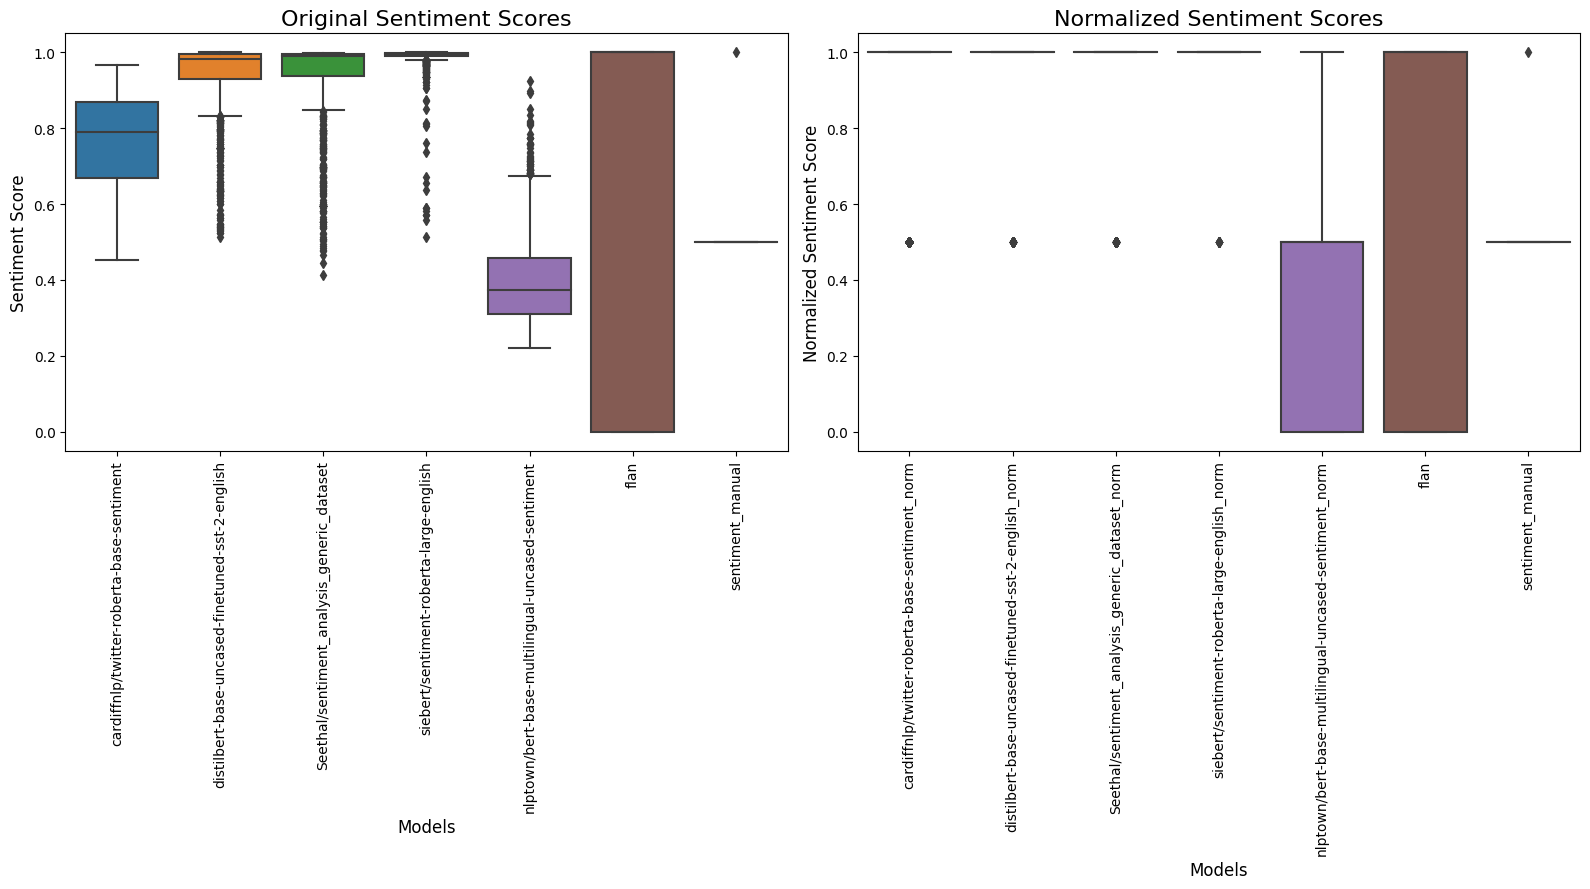

In [32]:
# Plot the results of the different sentiment annotations and add the manual annotations to the boxplot

# Create the subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 9))

# Boxplot for the original scores retrieved from the models
sns.boxplot(ax=axes[0], data=sampled_documents[models + ['flan','sentiment_manual']])
axes[0].set_title('Original Sentiment Scores', fontsize=16)
axes[0].set_xlabel('Models', fontsize=12)
axes[0].set_ylabel('Sentiment Score', fontsize=12)
axes[0].tick_params(axis='x', rotation=90)

# Boxplot for the normalized scores
sns.boxplot(ax=axes[1], data=sampled_documents[[model + '_norm' for model in models] + ['flan','sentiment_manual']])
axes[1].set_title('Normalized Sentiment Scores', fontsize=16)
axes[1].set_xlabel('Models', fontsize=12)
axes[1].set_ylabel('Normalized Sentiment Score', fontsize=12)
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

## LLM Annotation
Based on the comparison, XY demonstrated best results to annotate the ESG documents. This LLM with the respective prompting strategy is used to annotate all sentences.

In [ ]:
# Craete new column to store the sentence sentiment
documents['sentiment_llm'] = np.nan

In [ ]:
# Group by the 'original_index' and aggregate the columns
documents = documents.groupby('original_index').agg({
    # Use 'first' function for all columns except for 'sentence_tokens' and 'sentence_sentiment_value_llm'
    'title': 'first',  
    'company': 'first',  
    'datatype': 'first',  
    'date': 'first',  
    'domain': 'first',  
    'esg_topics': 'first',  
    'internal': 'first',  
    'symbol': 'first',  
    'title': 'first',  
    'cleaned_content': 'first',  
    'word_tokens': 'first',  
    'sentence_tokens': list,  # Combine the 'sentence_tokens' into a list
    'sentence_tokens': 'first',  
    'pos_tagged_word_tokens': 'first',  
    'pos_tagged_sentence_tokens': 'first',  
    'market_cap_in_usd_b': 'first',  
    'sector': 'first',  
    'industry': 'first',  
    'sentiment_value': 'first',  
    'cnt_word': 'first',  
    'cnt_sentence': 'first',  
    'cnt_esg': 'first',  
    'ratio_word_sentence': 'first',  
    'year_month': 'first',  
    'year': 'first',  
    'month': 'first',  
    'sentence_sentiment_value_llm': lambda x: [i if pd.notnull(i) else np.nan for i in x]  # Combine the 'sentence_sentiment_value_llm' into a list, substituting NaN where no manual sentiment was added
})

# Reset the index
documents = documents.reset_index(drop=True)